In [1]:
import os
import pickle
import copy
import random
import logging
import argparse
import pandas

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from collections import defaultdict

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from timeit import default_timer as timer
from datetime import timedelta

from blocks import VAE
from dataset import MorphologyDatasetTask3, Vocabulary

from blocks_main import initialize_model, initialize_dataloader

from main import get_max_seq_len

In [2]:
def plot_TSNE(z_list, l_list=None, hide_axis=True, pca_components=50, num_clusters=10):
    
    if pca_components is not None:
        pca    = PCA(n_components=pca_components)
        z_list = pca.fit_transform(z_list)

    X_reduced = TSNE(n_components=2, random_state=0).fit_transform(z_list)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=l_list[:], marker='o', edgecolor='none', 
                cmap=plt.cm.get_cmap('tab20', num_clusters), alpha=0.8)
    plt.colorbar(ticks=range(num_clusters))
    plt.grid(linestyle='--', linewidth=0.5)

    axes = plt.gca()
    
    if hide_axis:
        plt.axis('off')

    plt.show()

### Word VAE 

In [ ]:
def get_z_VAE(model, test_loader):

    model.eval()
    z_list = None
    it_sup = iter(test_loader)
    i      = 0

    while True:
        try:
            sample_batched_sup = next(it_sup)
        except StopIteration:
            break

        x_t_sup = sample_batched_sup['target_form'].to(device)
        x_t_sup = torch.transpose(x_t_sup, 0, 1)

        outputs, mu, logvar = model(x_t_sup)

        z = model.reparameterize(mu, logvar)
        
        if i == 0:
            z_list = z.detach().cpu().numpy()
        else:
            z_list = np.concatenate((z_list, z.detach().cpu().numpy()), axis=0)
        
        i += 1
        
        if i == 10000:
            break

    print("Num test points = {}".format(str(i)))
    return z_list

In [ ]:
language = 'turkish'
model_id = '1'

device         = torch.device('cpu')
checkpoint     = torch.load('../models/vae_{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

test_loader, d = initialize_dataloader(run_type='train', language=config['language'], task='sup',
                                       vocab=vocab, batch_size=1, shuffle=True)
idx_2_char     = d.idx_2_char

model          = initialize_model(config)
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
z_list = get_z_VAE(model, test_loader)

plot_TSNE(z_list, hide_axis=False)

### Labeled MSVAE

In [30]:
def get_z_MSVAE(model, test_loader, unique_keys, idx_2_char):

    model.eval()
    z_list = None
    l_list = []
    it_sup = iter(test_loader)
    i      = 0

    while True:
        try:
            sample_batched_sup = next(it_sup)
        except StopIteration:
            break

        x_t_sup = sample_batched_sup['target_form'].to(device)
        y_t_sup = sample_batched_sup['msd'].to(device)

        x_t_sup = torch.transpose(x_t_sup, 0, 1)
        y_t_sup = torch.transpose(y_t_sup, 0, 1)

        outputs, mu, logvar = model(x_t_sup, y_t_sup)
#         z                   = model.reparameterize(mu, logvar)
        z = mu
        
        if i == 0:
            z_list = z.detach().cpu().numpy()
        else:
            z_list = np.concatenate((z_list, z.detach().cpu().numpy()), axis=0)
            
        print(outputs.size())

        outputs     = outputs[1:].view(-1, outputs.shape[-1])
        outputs     = F.log_softmax(outputs, dim=1).type(torch.LongTensor)
        outputs     = torch.squeeze(outputs, 1)
        print(outputs.size())
        
        target_word = ''
        for j in outputs:
            p      = np.argmax(j, axis=0).detach().cpu().item()
            entity = idx_2_char[p]

            if   entity == '<SOS>':
                continue
            elif entity == '<PAD>' or entity == '<EOS>':
                break

            target_word += idx_2_char[p]

        print('actual: {}, predicted: {}'.format(sample_batched_sup['target_str'][0], target_word))

        x_s_raw = sample_batched_sup['source_str'][0]
        label   = unique_keys.index(x_s_raw)
        l_list.append(label)
        i += 1
        
#         if i == 70:
#             break

    print("Num test points = {}".format(str(i)))
    return z_list, l_list

In [12]:
language = 'turkish'
model_id = '5'

device         = torch.device('cpu')
checkpoint     = torch.load('../models/vae_{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

max_seq_len    = get_max_seq_len(language, vocab)
csvpath        = '../data/{}_stem_greater_12'.format(language)
d              = MorphologyDatasetTask3(test=True, language=language, vocab=vocab, tasks=['none'], get_unprocessed=True,
                                        max_unsup=10000, max_seq_len=max_seq_len, csvpath=csvpath)
test_loader    = DataLoader(d, batch_size=1, shuffle=False, num_workers=2)


idx_2_char     = d.idx_2_char

model          = initialize_model(config)
model.load_state_dict(checkpoint['model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
with open(csvpath, 'r') as f:
    source = f.read()

lines = source.strip().split('\n')

print('Total lines: {}'.format(len(lines)))

unique_x_s = defaultdict(int)
unique_msd = defaultdict(int)

for line in lines:
    words = line.strip().split('\t')
    msds  = words[1].strip().split(',')

    unique_x_s[words[0]] += 1

    for msd in msds:
        unique_msd[msd]  += 1

Total lines: 203


In [32]:
z_list, l_list = get_z_MSVAE(model, test_loader, list(unique_x_s.keys()), idx_2_char)

torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlerden, predicted: alametlerinde
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlere, predicted: alametlerinde
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alamete, predicted: alametl
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alamette, predicted: alameti
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlerimizden, predicted: alametlerin
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlerinize, predicted: alametlerind
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametinize, predicted: alameti
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlerini, predicted: alametlerini
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlerine, predicted: alametlerinie
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlerinde, predicted: alametlerini
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: alametlerinde, predicted: alametlerinde
torch.Size([28,

torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kas, predicted: kasını
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kasımızı, predicted: kasımızı
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kasımızda, predicted: kasımız
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kasınızı, predicted: kasınız
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kasların, predicted: kaslarını
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kaslarını, predicted: kaslarını
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kaslarına, predicted: kaslarına
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kaslarında, predicted: kaslarını
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kasları, predicted: kaslarını
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kasından, predicted: kasını
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kasını, predicted: kasını
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: kaslarının, predicted: kaslarını
torch.S

torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliklerin, predicted: yeterlilikleriniz
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterlilikler, predicted: yeterlilikleriniz
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliklerimizin, predicted: yeterlilikleriniz
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliğimiz, predicted: yeterliliğimiz
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliğimi, predicted: yeterliliğim
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliğim, predicted: yeterliliğim
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliğiniz, predicted: yeterliliğimiz
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliklerinin, predicted: yeterlilikleriniz
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliğin, predicted: yeterliliği
torch.Size([28, 1, 39])
torch.Size([27, 39])
actual: yeterliliğinde, predicted: yeterliliği
torch.Size([28, 1, 39])
torch.Size([27, 39])


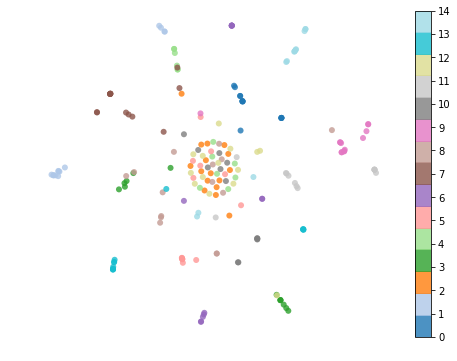

In [33]:
plot_TSNE(z_list, l_list, num_clusters=len(set(l_list)), pca_components=None)

## Predict $y_t$ given $x_t$

In [ ]:
language = 'turkish'
model_id = 1